# Full model $R_{t}$ analysis

Analysis of results for a model with a fixed reporting bias based on a dirichlet prior, as well as an unknown, time-varying Rt value. This model explicitly accounts for the presence of reporting bias.

In [21]:
import datetime
import os
import stan
import nest_asyncio

import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '16'
plt.style.use('default')

import periodic_sampling as ps
from periodic_sampling.synthetic_data import RenewalModel, Reporter

In [3]:
# Used for smoothing stepped R profile

def smoothen_Rt(my_list, window):
    f_padding = [my_list[0]] * window
    smooth_list = list(pd.Series(f_padding + my_list).rolling(window=window, min_periods=1, center=True).mean())
    return smooth_list[window:]

In [46]:
# Simulate Renewal Model - same parameters as in benchmark_analysis
time_steps = 100; N_0 = 100; seed=42; R0_diff = 0.25
start_date = '01/01/2020'; bias_method = 'poisson'

bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]  # Always given with monday first
R0_list = ([1.0 + R0_diff] * int(time_steps/2)) + ([1.0 - R0_diff] * int(time_steps/2))
images_path = "full_model/synthetic_inference/stepped_R/"

np.random.seed(seed)
model = RenewalModel()
model.simulate(T=time_steps, N_0=N_0, R_0=R0_list);

# Report unbiased and biased data
rep = Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease

truth_df = rep.unbiased_report()
bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 79332.40it/s]


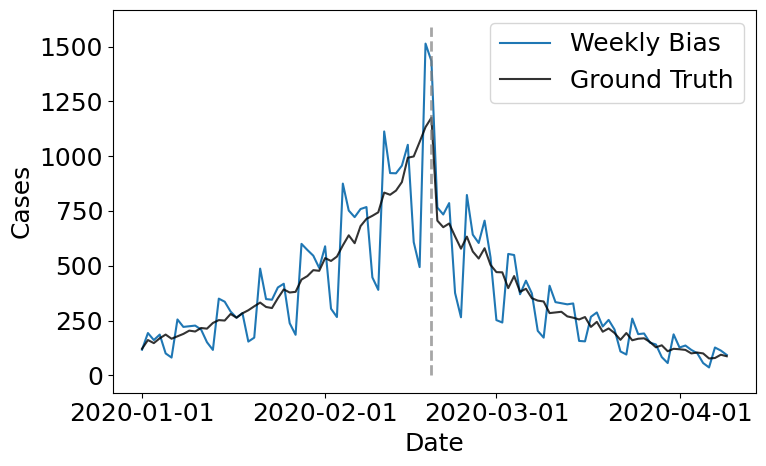

In [47]:
# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Weekly Bias')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
mid_date = truth_df['Date'][int((len(truth_df['Date'])-1)/2)]
plt.vlines(x=mid_date, ymin=0, ymax=plt.gca().get_ylim()[1], color='grey', linewidth=2, linestyle = 'dashed', alpha = 0.7)
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases"); axs.set_xticks(axs.get_xticks()[::2]);
plt.legend(); plt.tight_layout()

In [59]:
nest_asyncio.apply()  # Required to run pystan in jupyter notebooks
# https://pystan.readthedocs.io/en/latest/faq.html#how-can-i-use-pystan-with-jupyter-notebook-or-jupyterlab

with open(os.path.join(os.getcwd(), "full_model/full_model.stan")) as f:
    fixed_bias_code = f.read()

c_val = list(bias_df['Confirmed'])

fixed_bias_data = {
    "time_steps": len(c_val),
    "C": c_val,
    "Rt_window": 2,
    "serial_interval": RenewalModel(R0=None).serial_interval,
    "alpha_prior": [1 for _ in range(7)]  # larger val -> tighter dist
}

posterior = stan.build(fixed_bias_code, data=fixed_bias_data, random_seed=1) 

chain_num = 4
sample_num = int(2e4)
bias_init_val = [1/7 for _ in range(7)]  # ((i+1)/28) for simplex step
rt_init_val = [1 for _ in range(fixed_bias_data['time_steps'])]
init_values = [{'alpha': bias_init_val, 'R': rt_init_val} for _ in range(chain_num)] 

fit = posterior.sample(num_chains=chain_num, num_samples=sample_num, 
                       num_thin=int(2e2),
                       init=init_values,
                       )
df = fit.to_frame()
output = df[df.columns.drop([c for c in df.columns if c.startswith('alpha')])]
print(output.describe().T)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ybs15s0n/model_dq5yrh5g.stan', line 28, column 12: A
    control flow statement inside function calculate_lambda depends on
    argument I. At '/tmp/httpstan_ybs15s0n/model_dq5yrh5g.stan', line 68,
    column 53 to column 54, the value of I depends on parameter(s): I.
Warning in '/tmp/httpstan_ybs15s0n/model_dq5yrh5g.stan', line 21, column 12: A
    control flow statement inside function calculate_lambda depends on
    argument I. At '/tmp/httpstan_ybs15s0n/model_dq5yrh5g.stan', line 68,
    column 53 to column 54, the value of I depends on parameter(s): I.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/84000)
Sampling:   0% (2/84000)
Sampling:   0% (3/84000)
Sampling:   0% (4/84000)
Sampling:   0% (103/8400

               count           mean        std            min            25%  \
parameters                                                                     
lp__           400.0  201128.166400  10.361703  201095.908826  201121.158706   
accept_stat__  400.0       0.842940   0.125158       0.446602       0.772271   
stepsize__     400.0       0.272366   0.011191       0.253374       0.270376   
treedepth__    400.0       4.762500   0.844320       4.000000       4.000000   
n_leapfrog__   400.0      42.640000  29.531860      15.000000      15.000000   
...              ...            ...        ...            ...            ...   
bias.3         400.0       1.065930   0.019916       0.996170       1.051514   
bias.4         400.0       1.083907   0.020413       1.018299       1.070452   
bias.5         400.0       1.087504   0.021873       1.021710       1.073872   
bias.6         400.0       0.590892   0.014469       0.551327       0.580770   
bias.7         400.0       0.497878   0.

In [60]:
def rename_col(col):
    col = col.replace('.', '_')
    return col[:5] + str(int(col[5:])-1) if col.startswith('bias') else col

# output = pd.read_csv("hidden_stan_inference_T_poisson_600_N0_10000_R_n_10_R0diff_0.05_It_20000_seed_41.csv")
step_num = 5000; images_path = "stepped_profile/"; 

output.columns = map(rename_col, output.columns)  # Only run this once!

Bias_0: 0.498 +/- 0.012
Bias_1: 1.425 +/- 0.023
Bias_2: 1.248 +/- 0.024
Bias_3: 1.066 +/- 0.02
Bias_4: 1.084 +/- 0.02
Bias_5: 1.088 +/- 0.022
Bias_6: 0.591 +/- 0.014


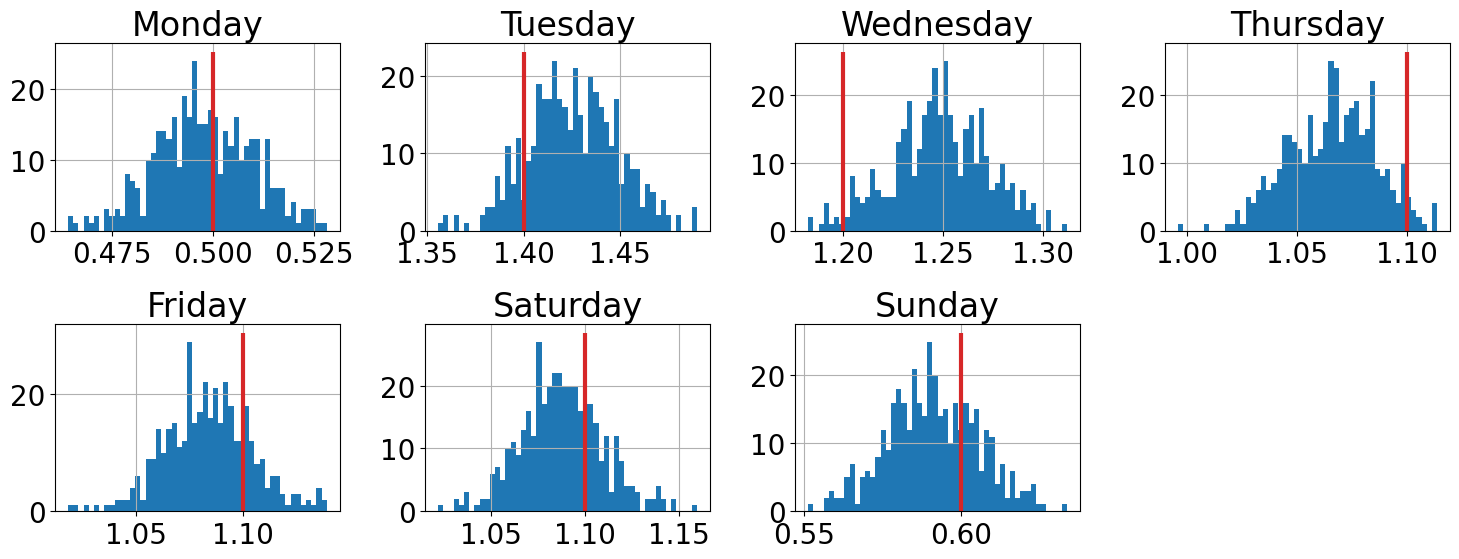

In [61]:
plt.rcParams['font.size'] = '20'

start_index = datetime.datetime.strptime(start_date, "%d/%m/%Y").weekday() - 1
output_bias = [np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 1) for i in range(7)]

histos = output.hist([("bias_" + str((i - start_index) % 7)) for i in range(7)], bins=50, figsize=(15, 6), layout=(2,4));
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(7):
    histos.flatten()[i].set_title(weekdays[i])
    histos.flatten()[i].vlines(x=bias[i], ymin=0, ymax=histos.flatten()[i].get_ylim()[1], color='tab:red', linewidth=3)
plt.gcf().patch.set_facecolor('white'); plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
# plt.savefig(images_path + f"biases_only_posterior_{bias_method}_T_{time_steps}_N0_{N_0}_Rn_{R_n}_R0diff_{R0_diff}_It_{step_num}_seeds_{seed}_win_2.png")

for i in range(7):
    mean = np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 3)
    std = np.round(np.std(output['bias_' + str((i - start_index) % 7)]), 3)

    print(f"Bias_{i}: {mean} +/- {std}")

In [62]:
print(start_index)

1


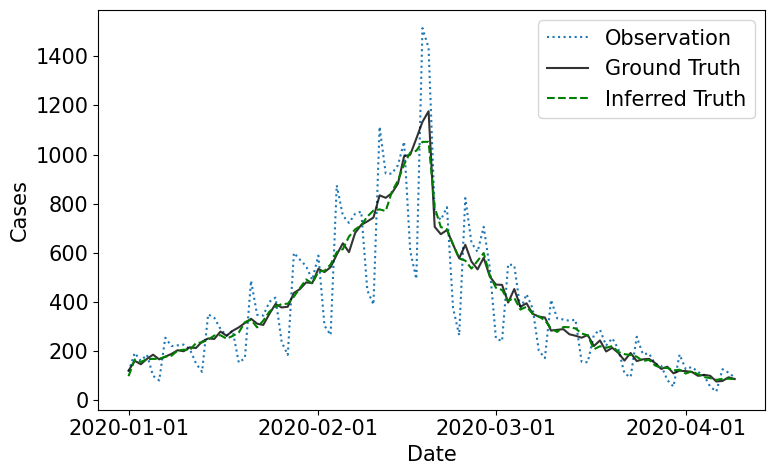

In [63]:
plt.rcParams['font.size'] = '15'
predicted_truth = []  

for index in range(1, time_steps + 1):
    predicted_truth.append(np.mean(output['I_' + str(index)]))

# Plot bias in data
fig, ax = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=ax, color='tab:blue', label = 'Observation', linestyle = 'dotted')
truth_df.plot(x='Date', y='Confirmed', ax=ax, color='black', label = 'Ground Truth', alpha=0.8)
ax.plot(truth_df['Date'], predicted_truth, color='green', label = 'Inferred Truth', linestyle = 'dashed')

mid_date = truth_df['Date'][int((len(truth_df['Date'])-1)/2)]
# ax.vlines(x=mid_date, ymin=0, ymax=ax.get_ylim()[1], color='grey', linewidth=2, linestyle = 'dashed', alpha = 0.7)
ax.set_xticks(ax.get_xticks()[::2]);
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.tight_layout()
# plt.savefig(images_path + f"biased_reconstruction_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

Average error: 6.3242%


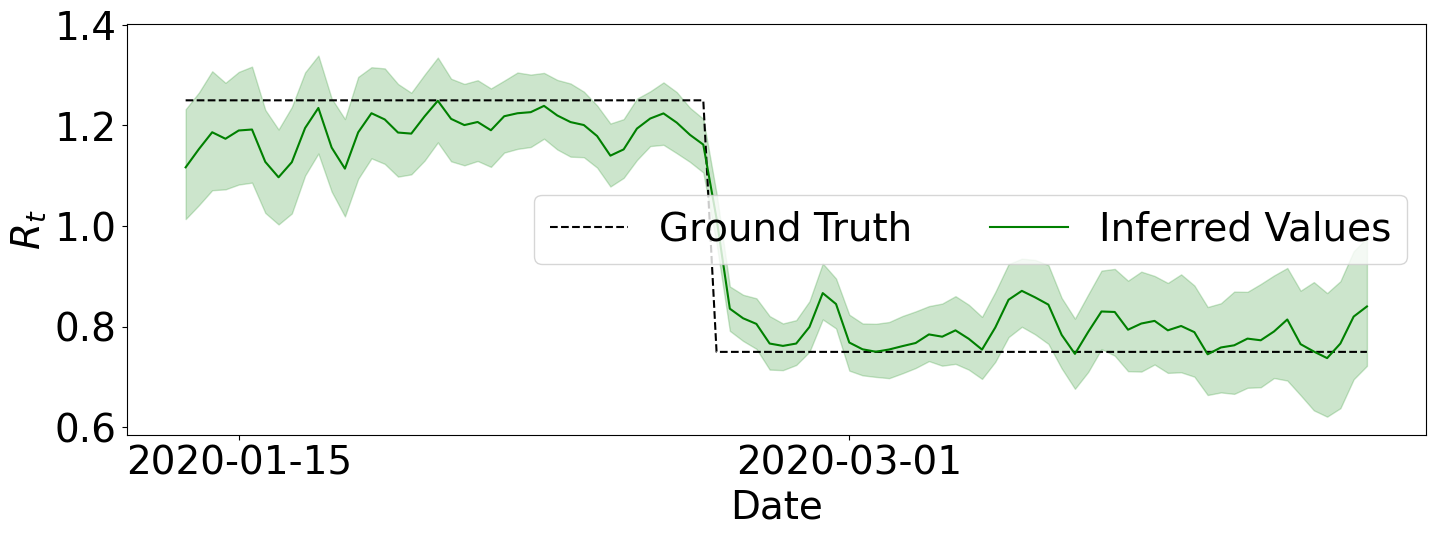

In [64]:
plt.rcParams['font.size'] = '28'; interval_range = 90; window = 10
predicted_R = []; upper_R = []; lower_R = []
percentile = (100-interval_range) / 2


for index in range(1, time_steps+1):
    predicted_R.append(np.mean(output['R_' + str(index)]))
    upper_R.append(np.percentile(output['R_' + str(index)], 100-percentile))
    lower_R.append(np.percentile(output['R_' + str(index)], percentile))

# Plot bias in data
fig, ax = plt.subplots(1, figsize=(15, 6))

ax.plot(truth_df['Date'][window:], R0_list[window:], color='black', label = 'Ground Truth', linestyle = 'dashed')
ax.plot(truth_df['Date'][window:], predicted_R[window:], color='green', label = 'Inferred Values')
ax.fill_between(truth_df['Date'][window:], lower_R[window:], upper_R[window:], color = 'green', alpha=0.2)
ax.set_ylim([ax.get_ylim()[0],ax.get_ylim()[1]*1.02])
ax.set_xticks(ax.get_xticks()[::3]);
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("$R_{t}$")
plt.legend(ncol=2); plt.tight_layout()
# plt.savefig(images_path + f"Rt_reconstruction_{bias_method}_T_{time_steps}_N0_{N_0}_Rn_{R_n}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}_win_2.png")

diff = np.sqrt(np.square(np.array(R0_list) - np.array(predicted_R)))
print(f"Average error: {100 * np.mean(diff / R0_list):.4f}%")

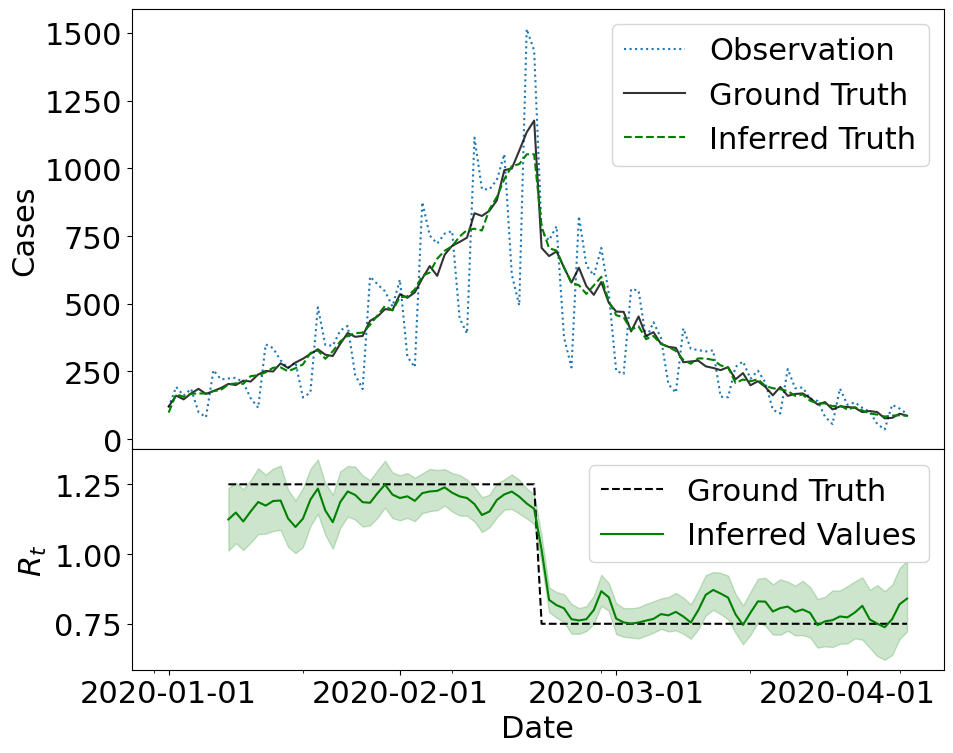

In [65]:
# combined plot for both timeseries and r
plt.rcParams['font.size'] = '22'
fig = plt.figure(figsize=(10, 8))

gs = fig.add_gridspec(2, 1,  height_ratios=(6, 3), hspace = 0)
                    #   left=0, right=1, bottom=0, top=1)
                    #   wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[0, 0])
ax_r = fig.add_subplot(gs[1, 0], sharex=ax)                     

bias_df.plot(x='Date', y='Confirmed', ax=ax, color='tab:blue', label = 'Observation', linestyle = 'dotted')
truth_df.plot(x='Date', y='Confirmed', ax=ax, color='black', label = 'Ground Truth', alpha=0.8)
ax.plot(truth_df['Date'], predicted_truth, color='green', label = 'Inferred Truth', linestyle = 'dashed')
ax.get_xaxis().set_visible(False); ax.legend(); ax.set_ylabel("Cases");

ax_r.plot(truth_df['Date'][8:], R0_list[8:], color='black', label = 'Ground Truth', linestyle = 'dashed')
ax_r.plot(truth_df['Date'][8:], predicted_R[8:], color='green', label = 'Inferred Values')
ax_r.fill_between(truth_df['Date'][8:], lower_R[8:], upper_R[8:], color = 'green', alpha=0.2)

ax_r.set_xticks(ax.get_xticks()[::2]); ax_r.legend()
plt.xlabel("Date"); plt.ylabel("$R_{t}$")

plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
# plt.savefig(images_path + f"combined_series_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

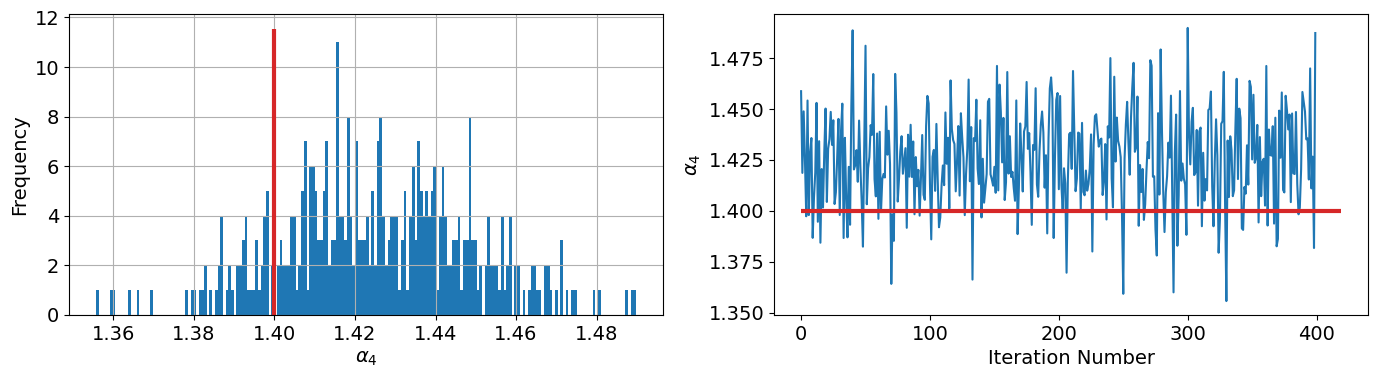

In [66]:
i = 0; bias_x = 'bias_' + str(i)
value = 1.4; bias_name = 'alpha{' + str(i) + '}'

plt.rcParams['font.size'] = '14'
fig, axs = plt.subplots(1, 2, figsize=(14,4))

histo = output.hist(bias_x, ax=axs[0], bins=200)
axs[0].vlines(x=value, ymin=0, ymax=axs[0].get_ylim()[1], color='tab:red', linewidth=3)
axs[0].set_xlabel(r'$\alpha_{4}$'); axs[0].set_ylabel('Frequency'); axs[0].set_title('');

if ('Chain' in output.columns):
    chains = output['Chain'].unique()
    for chain in chains:
        index = output.index[output['Chain']==chain]
        # axs[1].plot(index % len(index), output[bias_x][output['Chain']==chain])
        axs[1].plot((pd.Series([x for x in range(len(index) + 1)]) % len(index + 1))[:-1],
                    (pd.concat([pd.Series([1.2]), output[bias_x][output['Chain']==chain]]))[:-1], alpha=0.7)
else:
    axs[1].plot(output.index, output[bias_x])
axs[1].hlines(y=value, xmin=0, xmax=axs[1].get_xlim()[1], color='tab:red', linewidth=3)
axs[1].set_xlabel('Iteration Number'); axs[1].set_ylabel(r'$\alpha_{4}$'); axs[0].set_title('');

plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
# plt.savefig(images_path + f"{bias_x}_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

/tmp/ipykernel_2799881/2032631215.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Chain'] = 1


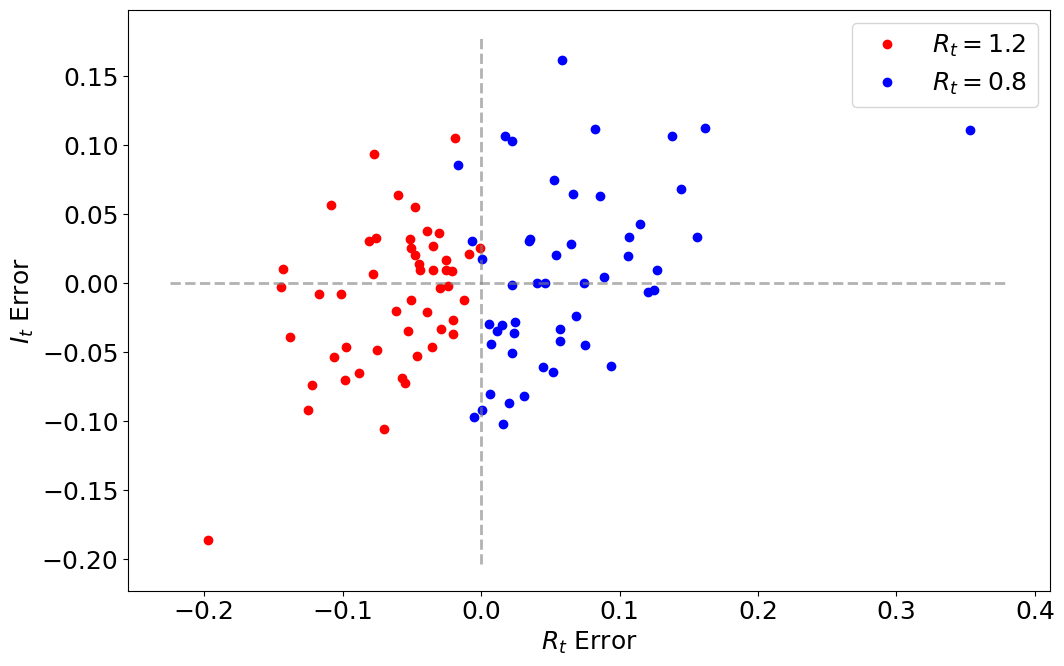

In [67]:
plt.rcParams['font.size'] = '18'
colors = ['r', 'b']; R_val = [1 + R0_diff, 1 - R0_diff]

if 'R_1' in output.columns:
    fig, axs = plt.subplots(1, 1, figsize=(11,7))
    for t in range(time_steps):
        if ('Chain' not in output.columns):
            output['Chain'] = 1
        chains = output['Chain'].unique()
        for chain in chains:
            index = output.index[output['Chain']==chain]
            axs.plot(
                np.mean((output['R_' + str(t+1)][output['Chain']==chain]) - R_val[t // int(time_steps /2)]) / R_val[t // int(time_steps /2)],
                # np.mean(output['bias_' + str(t % 7)][output['Chain']==chain]) - bias[(t + start_index) % 7],
                (np.mean(output['I_' + str(t+1)][output['Chain']==chain]) - truth_df['Confirmed'][t]) / truth_df['Confirmed'][t],
                marker='o', color = colors[t // int(time_steps /2)], linestyle = '')

    axs.hlines(y=0, xmin=axs.get_xlim()[0], xmax=axs.get_xlim()[1], color='gray', linewidth=2, alpha=0.6, linestyle='dashed')
    axs.vlines(x=0, ymin=axs.get_ylim()[0], ymax=axs.get_ylim()[1], color='gray', linewidth=2, alpha=0.6, linestyle='dashed')
    axs.set_xlabel(r'$R_{t}$ Error'); axs.set_ylabel(r'$I_{t}$ Error'); axs.set_title('');
    axs.lines[1].set_label(r'$R_{t} = 1.2$'); axs.lines[-1].set_label(r'$R_{t} = 0.8$')

    plt.gcf().patch.set_facecolor('white'); plt.legend(); plt.tight_layout();
    # plt.savefig(images_path + f"error_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

RMS Residual for Biased data: 141.3
RMS Residual for Rolling Average data: 83.66
RMS Residual for Bayesian Inference data: 25.31


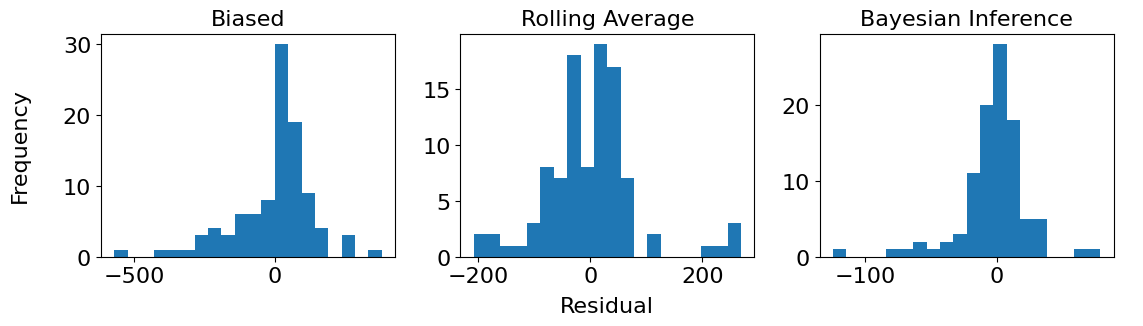

In [68]:
def rms(series):
    """Returns rms value for a series"""
    return np.power(np.sum(np.square(series)) / len(series), 1/2)

roll_ave_series = bias_df['Confirmed'].rolling(window=7).mean().bfill().ffill()
data_series = [bias_df['Confirmed'], roll_ave_series, predicted_truth]
labels = ['Biased', 'Rolling Average', 'Bayesian Inference']
font_size = 16

fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
for i in range(len(data_series)):
    residual = data_series[i] - truth_df['Confirmed']
    axs[i].hist(residual, bins=20); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"RMS Residual for {labels[i]} data: " + str(round(rms(residual), 2)))

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Frequency", fontsize=font_size); plt.xlabel('Residual', fontsize=font_size);
plt.tight_layout()
# plt.savefig(images_path + f"series_residuals_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

Expected lag for Biased data: 0.07 days
Expected lag for Rolling Average data: 2.10 days
Expected lag for Bayesian Inference data: 0.06 days


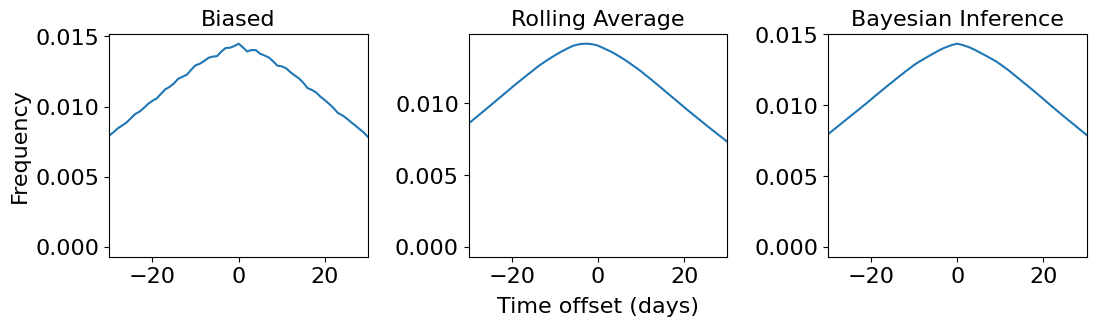

In [69]:
fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
for i in range(len(data_series)):
    cross_corr = np.correlate(truth_df['Confirmed'], data_series[i], mode='full').astype('float64')
    cross_corr /= sum(cross_corr)
    t_values = range(-len(truth_df['Confirmed']) + 1, len(truth_df['Confirmed']))
    expected_lag = np.dot(t_values, cross_corr)
    
    # cross_corr = np.divide(cross_corr, list(range(1,len(cross_corr)+2,2)) + list(range(1,len(cross_corr),2))[::-1])  # Normalise by number of contributing elements from timeseries
    axs[i].plot(t_values, cross_corr); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].set_xlim(-30, 30); #axs[i].set_yscale('log')
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"Expected lag for {labels[i]} data: {-expected_lag:.2f} days")

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axs[0].set_ylabel("Frequency", fontsize=font_size); plt.xlabel('Time offset (days)', fontsize=font_size);
plt.tight_layout()
# plt.savefig(images_path + f"series_crosscorr_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")